#Project Introduction
**The Indian education landscape has been undergoing rapid changes for the past 10 years owing to the advancement of web-based learning services, specifically, eLearning platforms. Global E-learning is estimated to witness an 8X over the next 5 years to reach USD 2B in 2021. India is expected to grow with a CAGR of 44% crossing the 10M users mark in 2021. Although the market is growing on a rapid scale, there are major challenges associated with digital learning when compared with brick and mortar classrooms. One of many challenges is how to ensure quality learning for students. Digital platforms might overpower physical classrooms in terms of content quality but when it comes to understanding whether students are able to grasp the content in a live class scenario is yet an open-end challenge. In a physical classroom during a lecturing teacher can see the faces and assess the emotion of the class and tune their lecture accordingly, whether he is going fast or slow. He can identify students who need special attention. Digital classrooms are conducted via video telephony software program (exZoom) where it’s not possible for medium scale class (25-50) to see all students and access the mood. Because of this drawback, students are not focusing on content due to lack of surveillance. While digital platforms have limitations in terms of physical surveillance but it comes with the power of data and machines which can work for you. It provides data in the form of video, audio, and texts which can be analysed using deep learning algorithms. Deep learning backed system not only solves the surveillance issue, but it also removes the human bias from the system, and all information is no longer in the teacher’s brain rather translated in numbers that can be analysed and tracked.**

#Problem Statements
**We will solve the above-mentioned challenge by applying deep learning algorithms to live video data. The solution to this problem is by recognizing facial emotions.**

In [68]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [69]:
# Importing all the required Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [70]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        print(os.listdir("../input"))

In [71]:
df='/content/drive/My Drive/'
data = pd.read_csv(df+'/Dataset/icml_face_data.csv')


In [72]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [73]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label
def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()

    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()    


#5. Callback Functions

In [74]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callbackFunction(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

#6. More about the dataset

In [75]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

#7. Creating the label dictionary

In [76]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

#8. Training, Testing and Validation Split

In [77]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [78]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255

val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255

test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [79]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)


#9. Examples from the dataset

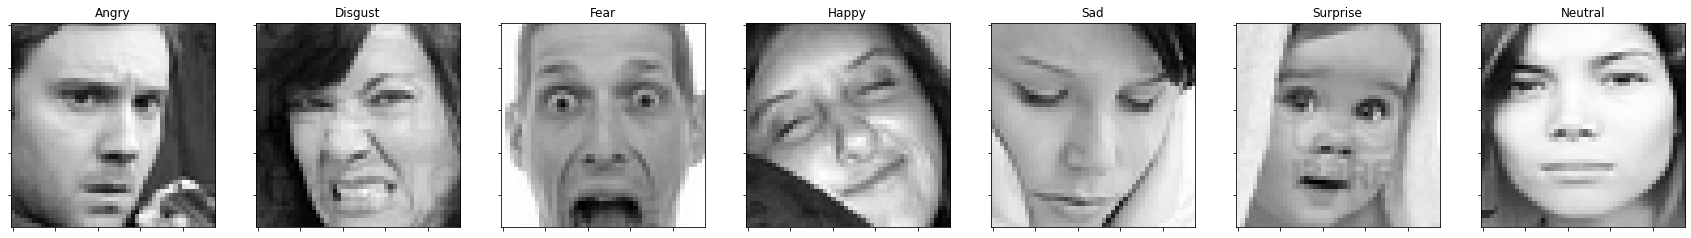

In [80]:
plot_all_emotions()

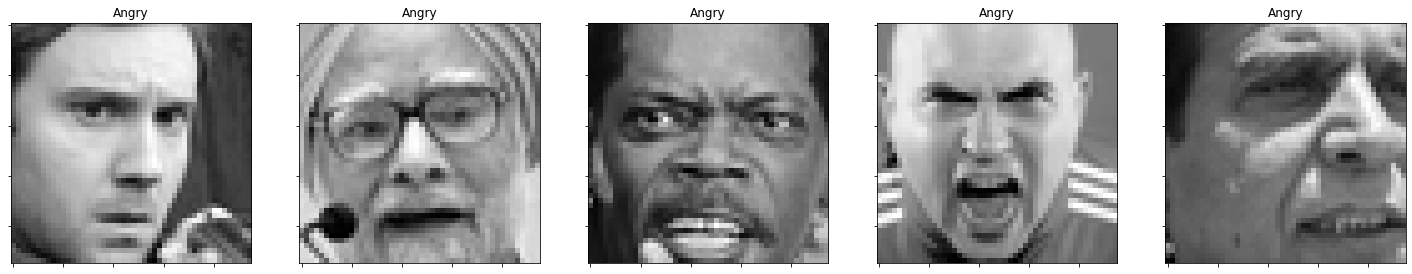

In [81]:
plot_examples(label=0)

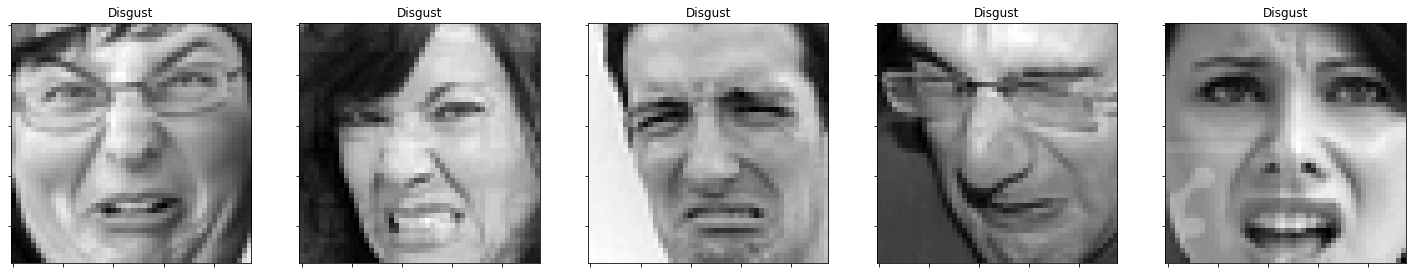

In [82]:
plot_examples(label=1)

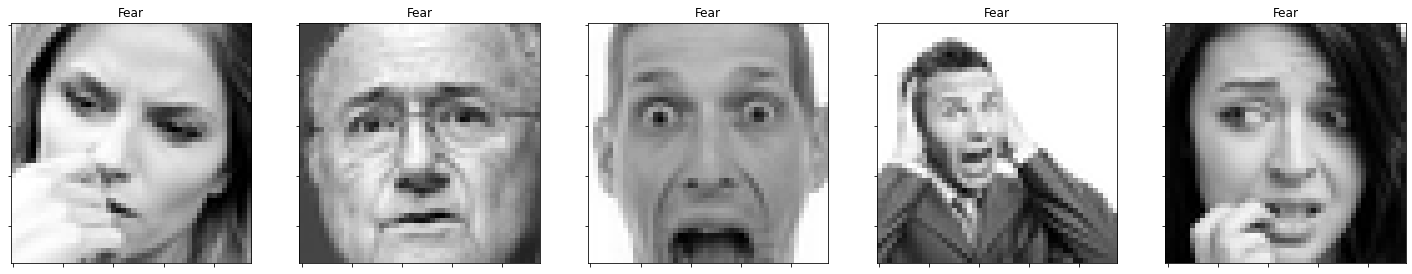

In [83]:
plot_examples(label=2)

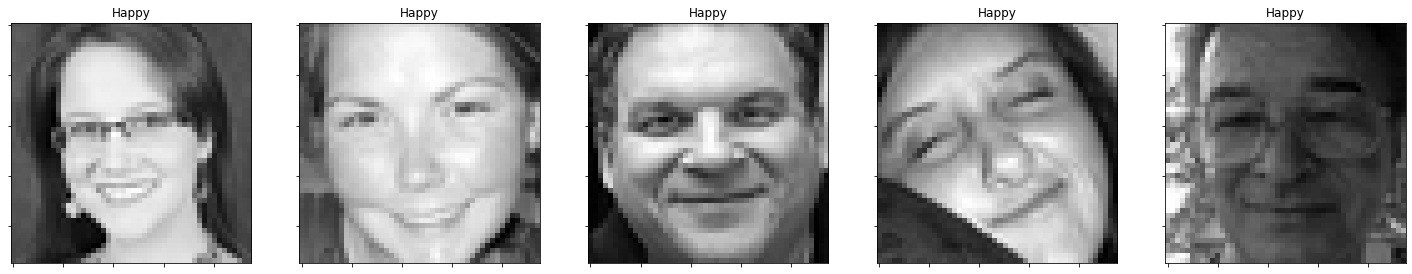

In [84]:
plot_examples(label=3)

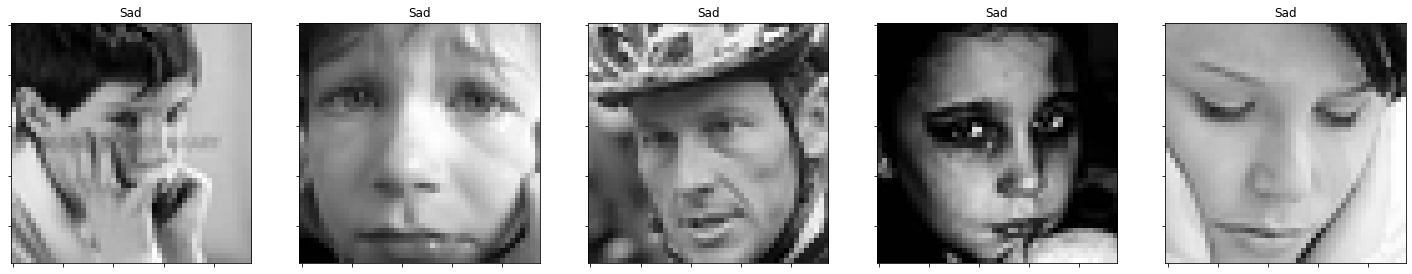

In [85]:
plot_examples(label=4)

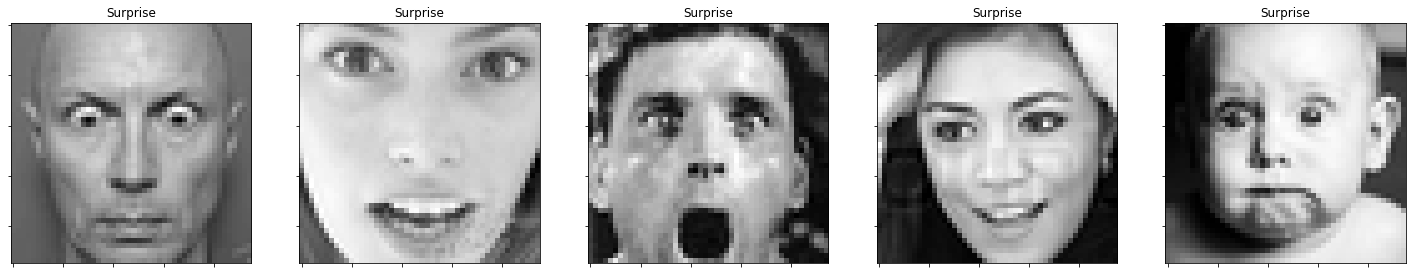

In [86]:
plot_examples(label=5)

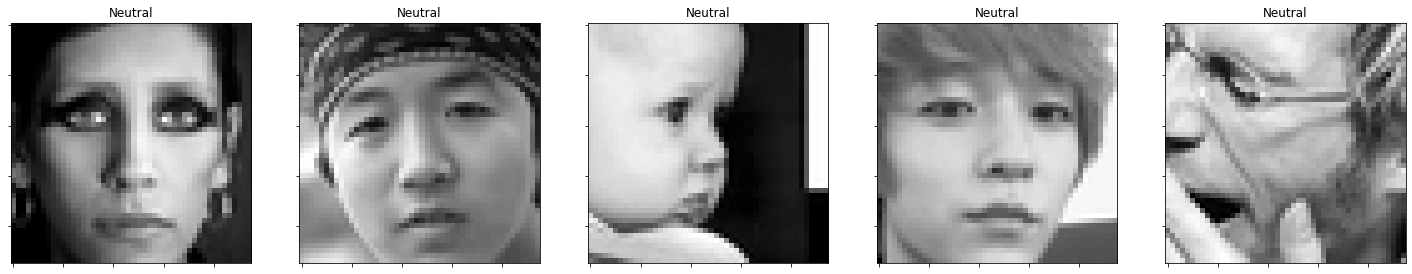

In [87]:
plot_examples(label=6)

#10. Comparison Plots

Train Labels and Validation Labels

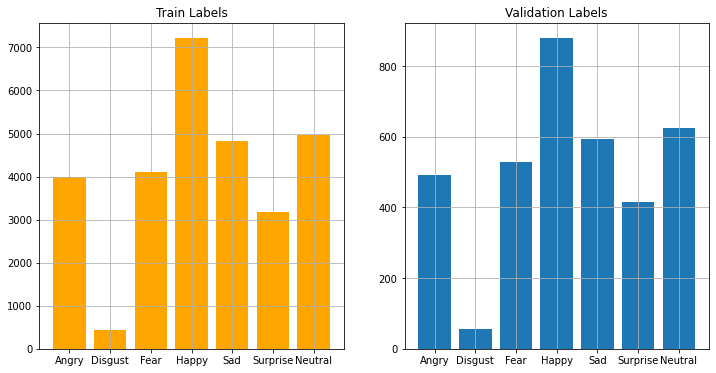

In [88]:
plot_compare_distributions(train_labels, val_labels, title1='Train Labels', title2='Validation Labels')

Train Labels and Test Labels

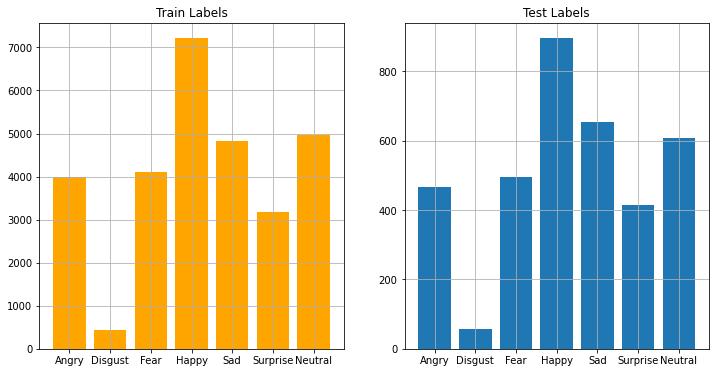

In [89]:
plot_compare_distributions(train_labels, test_labels, title1='Train Labels', title2='Test Labels')

#11. Weights

In [90]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

#12. Custom Model 1

With Convolution Layers, Pooldown Layers and Dense Layers

In [91]:
model1 = models.Sequential()

model1.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(64, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))

model1.add(MaxPool2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(128, activation='relu'))

model1.add(Dense(7, activation='softmax'))

#The Model

In [92]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 128)       

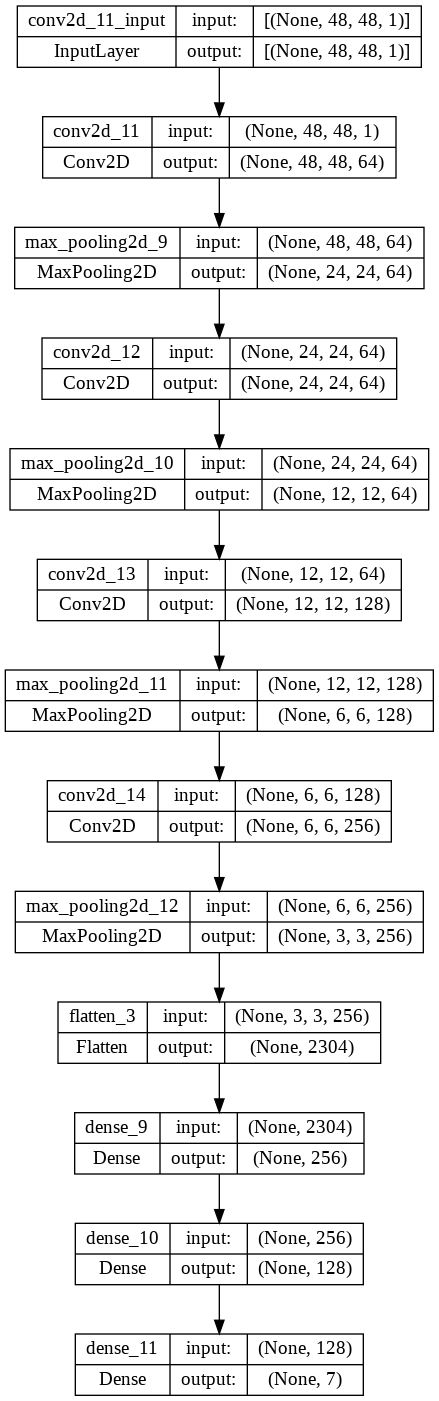

In [93]:
# Visualize the model.
plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [94]:
model1.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [95]:
history1 = model1.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
445/449 [============================>.] - ETA: 0s - loss: 0.2826 - accuracy: 0.2684
Epoch 1: val_accuracy improved from -inf to 0.38618, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 6s 12ms/step - loss: 0.2823 - accuracy: 0.2688 - val_loss: 1.6139 - val_accuracy: 0.3862
Epoch 2/50
445/449 [============================>.] - ETA: 0s - loss: 0.2336 - accuracy: 0.4102
Epoch 2: val_accuracy improved from 0.38618 to 0.44469, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.2334 - accuracy: 0.4103 - val_loss: 1.4716 - val_accuracy: 0.4447
Epoch 3/50
445/449 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.4734
Epoch 3: val_accuracy improved from 0.44469 to 0.47005, saving model to Checkpoints/Case_1.h5
449/449 [==============================] - 5s 11ms/step - loss: 0.2081 - accuracy: 0.4739 - val_loss: 1.3939 - val_accuracy: 0.4700
Epoch 4/50
447/449 [=================

Accuracy

In [96]:
train_loss, train_acc = model1.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model1.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model1.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 4s 4ms/step - loss: 0.1284 - accuracy: 0.9608
Training Accuracy: 96.08485102653503


113/113 [==============================] - 0s 4ms/step - loss: 3.5782 - accuracy: 0.5439
Testing Accuracy: 54.38840985298157


113/113 [==============================] - 0s 4ms/step - loss: 3.5459 - accuracy: 0.5475
Validation Accuracy: 54.750627279281616


Predictions

In [97]:
pred_test_labels1 = model1.predict(test_images)

113/113 [==============================] - 0s 3ms/step


Plots

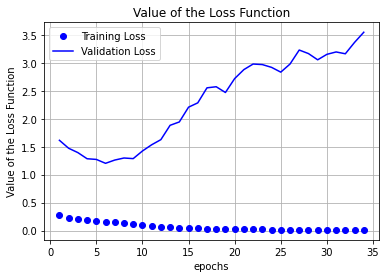

In [98]:
loss = history1.history['loss']
loss_val = history1.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, loss_val, 'b', label='Validation Loss')
plt.title('Value of the Loss Function')
plt.xlabel('epochs')
plt.ylabel('Value of the Loss Function')
plt.legend()
plt.grid()
plt.show()

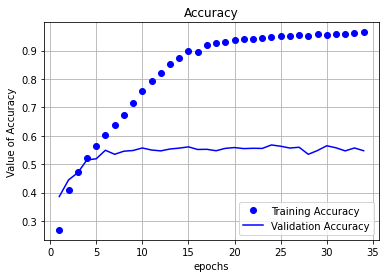

In [99]:
acc = history1.history['accuracy']
acc_val = history1.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Value of Accuracy')
plt.legend()
plt.grid()
plt.show()

#13. Custom Model 2

With Convolution Layers, Pooldown Layers, Dropout Layers and Dense Layers

In [100]:
model2 = models.Sequential()

model2.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(Dropout(0.25))

model2.add(MaxPool2D((2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.25))

model2.add(Dense(7, activation='softmax'))

The Model

In [101]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 dropout_10 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 24, 24, 64)        36928     
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                 

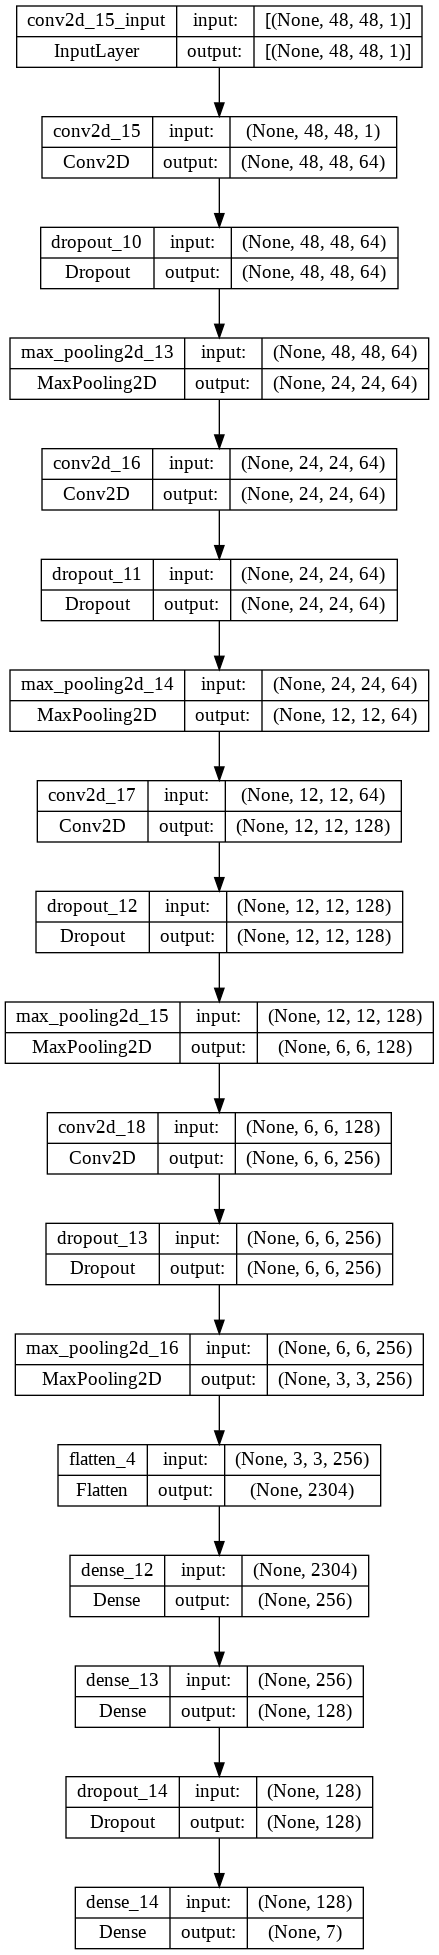

In [102]:
# Visualize the model.
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [103]:
model2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [104]:
history2 = model2.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_2'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2692 - accuracy: 0.3117
Epoch 1: val_accuracy improved from -inf to 0.39537, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2692 - accuracy: 0.3117 - val_loss: 1.5898 - val_accuracy: 0.3954
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2255 - accuracy: 0.4309
Epoch 2: val_accuracy improved from 0.39537 to 0.45417, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2255 - accuracy: 0.4309 - val_loss: 1.4631 - val_accuracy: 0.4542
Epoch 3/50
447/449 [============================>.] - ETA: 0s - loss: 0.2068 - accuracy: 0.4815
Epoch 3: val_accuracy improved from 0.45417 to 0.49178, saving model to Checkpoints/Case_2.h5
449/449 [==============================] - 7s 15ms/step - loss: 0.2068 - accuracy: 0.4817 - val_loss: 1.3598 - val_accuracy: 0.4918
Epoch 4/50
448/449 [=================

Accuracy

In [105]:
train_loss, train_acc = model2.evaluate(train_images, train_labels)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model2.evaluate(test_images, test_labels)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model2.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 3s 4ms/step - loss: 0.3060 - accuracy: 0.9294
Training Accuracy: 92.94297695159912


113/113 [==============================] - 1s 4ms/step - loss: 1.2538 - accuracy: 0.6024
Testing Accuracy: 60.23961901664734


113/113 [==============================] - 0s 4ms/step - loss: 1.2477 - accuracy: 0.6049
Validation Accuracy: 60.49038767814636


Predictions

In [106]:
pred_test_labels2 = model2.predict(test_images)

113/113 [==============================] - 0s 3ms/step


Plots

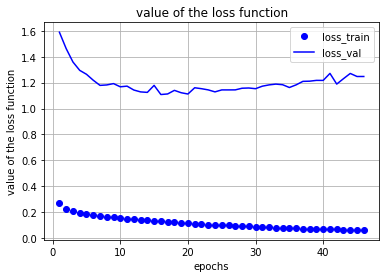

In [107]:
loss = history2.history['loss']
loss_val = history2.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

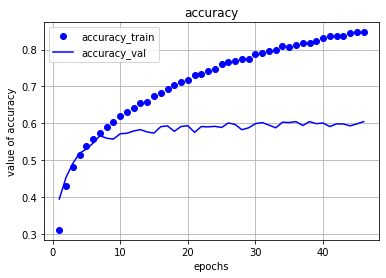

In [108]:
acc = history2.history['accuracy']
acc_val = history2.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#14. Custom Model 3

With Convolution Layers, Pooldown Layer, Droupout Layers, Batch Normalization and Dense Layers

In [109]:
model3 = models.Sequential()

model3.add(Conv2D(64, (1, 1), padding='same', activation='relu', input_shape=(48, 48, 1)))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))

model3.add(Conv2D(256, (5, 5),padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2),padding="same"))
model3.add(Dropout(0.25))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(256))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(Dropout(0.25))

model3.add(Dense(7, activation='softmax'))

The Model

In [110]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 48, 48, 64)        128       
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 48, 48, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_16 (Dropout)        (None, 48, 48, 128)      

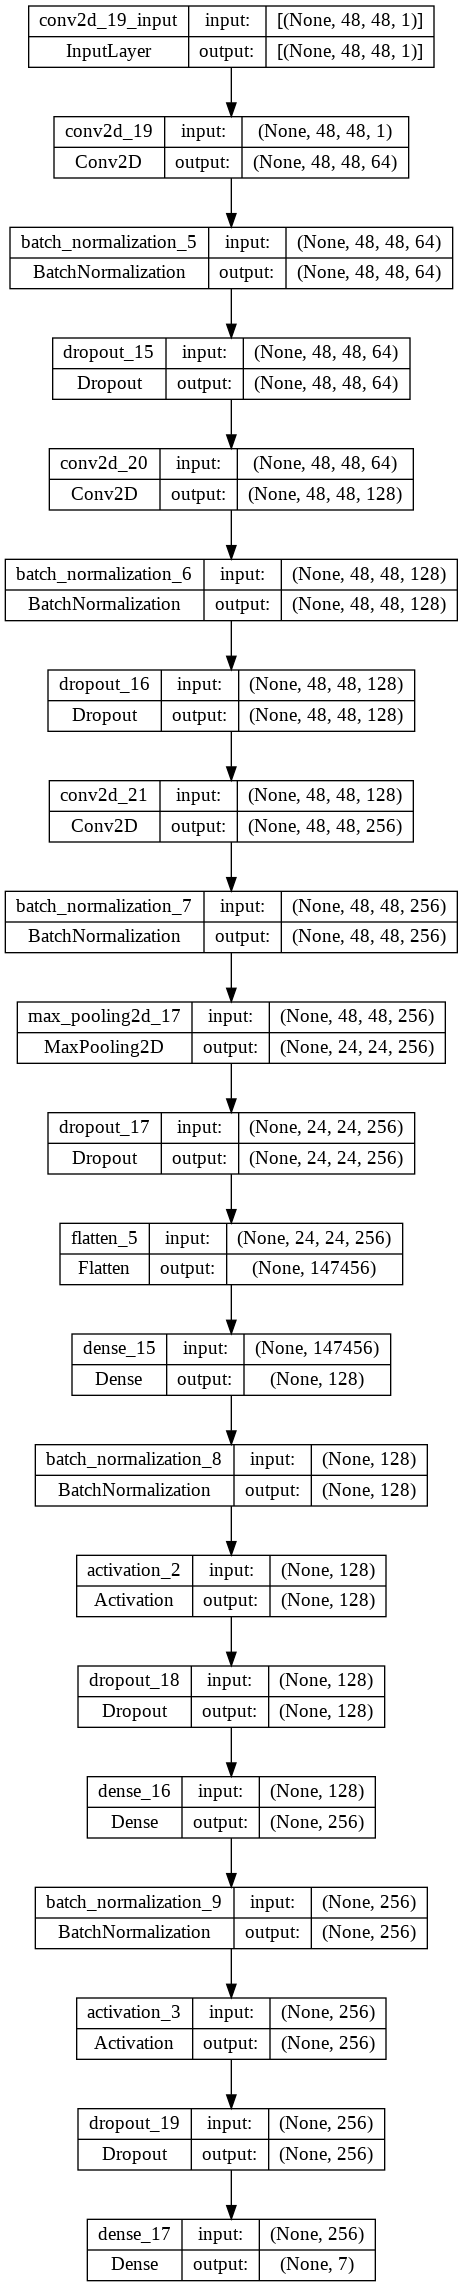

In [111]:
# Visualize the model.
plot_model(model3, to_file='model.png', show_shapes=True, show_layer_names=True)

Compiling the Model

In [112]:
model3.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

Training the Model

In [113]:
history3 = model3.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    callbacks=callbackFunction('Case_3'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50
449/449 [==============================] - ETA: 0s - loss: 0.2754 - accuracy: 0.3285
Epoch 1: val_accuracy improved from -inf to 0.32405, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 44s 95ms/step - loss: 0.2754 - accuracy: 0.3285 - val_loss: 1.6984 - val_accuracy: 0.3240
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.4417
Epoch 2: val_accuracy improved from 0.32405 to 0.47813, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 42s 94ms/step - loss: 0.2263 - accuracy: 0.4417 - val_loss: 1.3682 - val_accuracy: 0.4781
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.5091
Epoch 3: val_accuracy improved from 0.47813 to 0.49317, saving model to Checkpoints/Case_3.h5
449/449 [==============================] - 42s 94ms/step - loss: 0.1987 - accuracy: 0.5091 - val_loss: 1.3866 - val_accuracy: 0.4932
Epoch 4/50
449/449 [==============

Accuracy

In [114]:
train_loss, train_acc = model3.evaluate(train_images, train_labels)
print('Train Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model3.evaluate(test_images, test_labels)
print('Test Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model3.evaluate(val_images, val_labels)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 12s 13ms/step - loss: 0.0101 - accuracy: 0.9965
Train Accuracy: 99.6516764163971


113/113 [==============================] - 2s 14ms/step - loss: 2.7225 - accuracy: 0.5614
Test Accuracy: 56.1437726020813


113/113 [==============================] - 1s 13ms/step - loss: 2.6706 - accuracy: 0.5670
Validation Accuracy: 56.70102834701538


Predictions

In [ ]:
pred_test_labels3 = model3.predict(test_images)

Plots

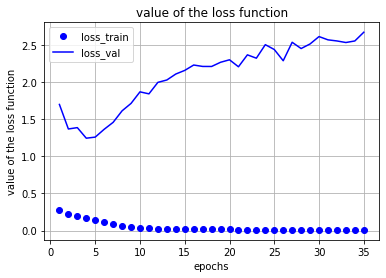

In [115]:
loss = history3.history['loss']
loss_val = history3.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

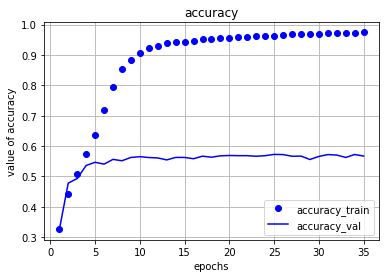

In [116]:
acc = history3.history['accuracy']
acc_val = history3.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

#15. Analyzing the Results

For Model 1

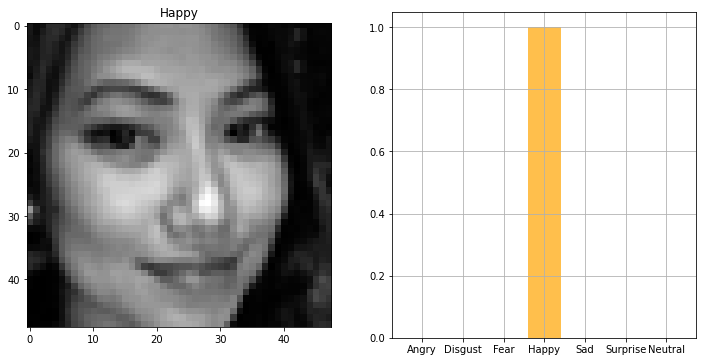

In [117]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 19)

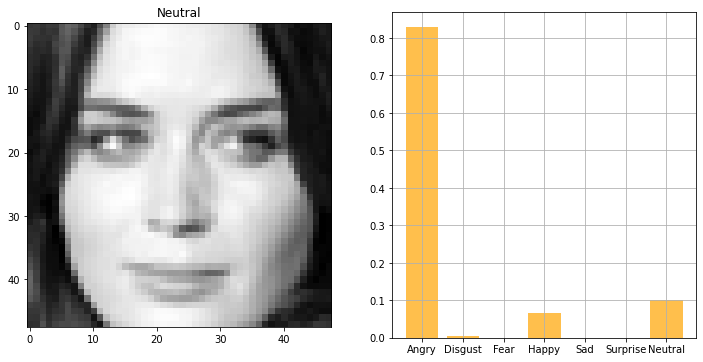

In [118]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels1, 119)

Form Model 2

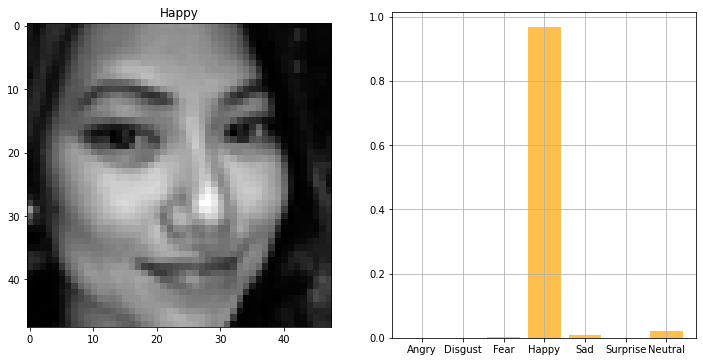

In [119]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 19)

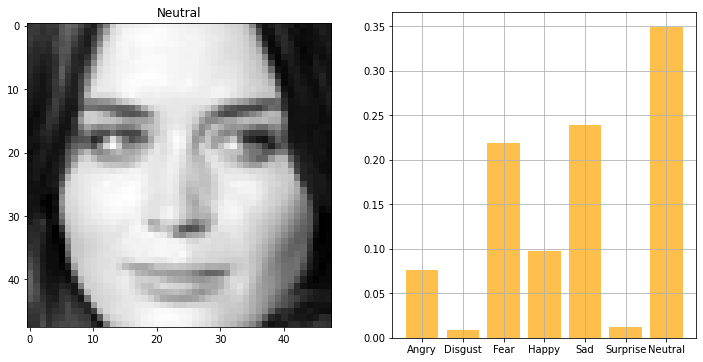

In [120]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels2, 119)

For Model 3

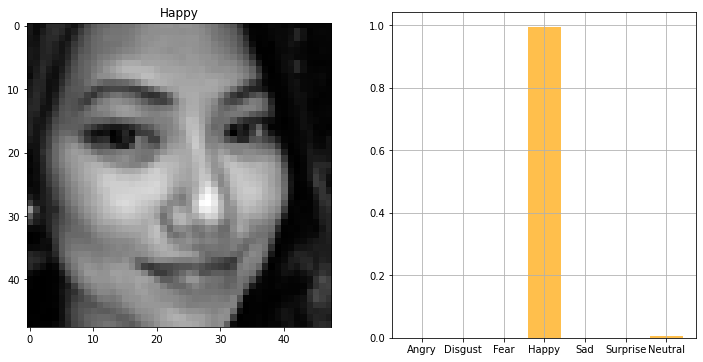

In [121]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 19)

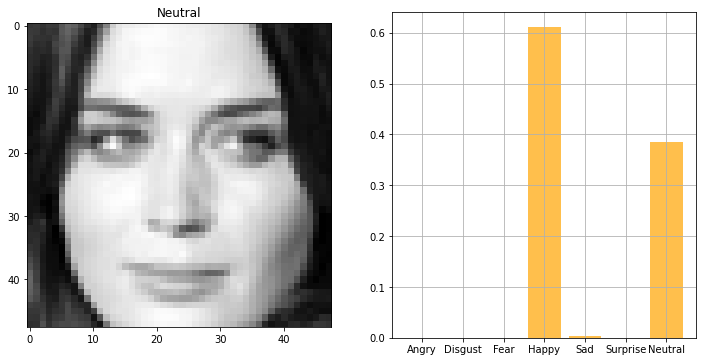

In [122]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels3, 119)

16. Predicted Label Comparision Plot

Model 1

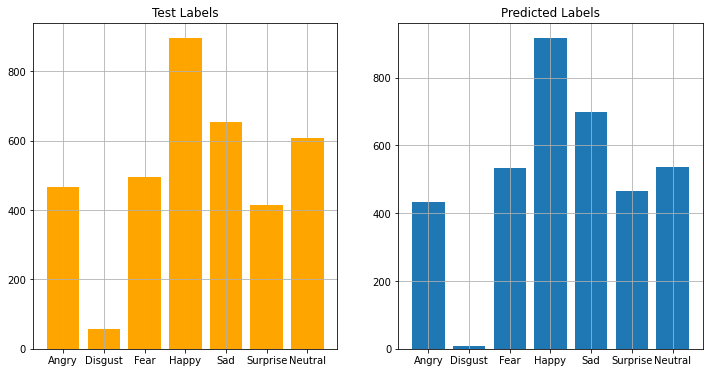

In [123]:
plot_compare_distributions(test_labels, pred_test_labels1, title1='Test Labels', title2='Predicted Labels')

Model 2

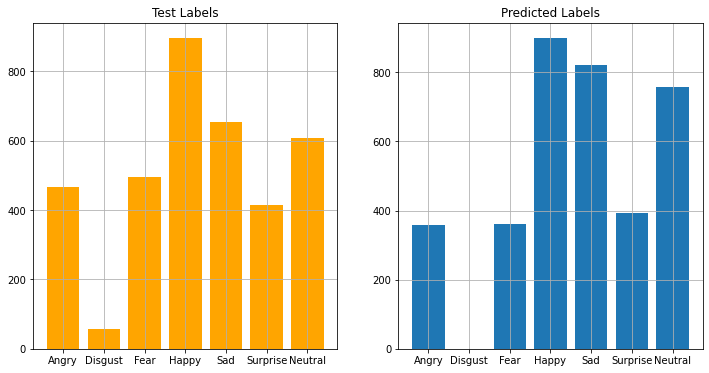

In [124]:
plot_compare_distributions(test_labels, pred_test_labels2, title1='Test Labels', title2='Predicted Labels')

Model 3

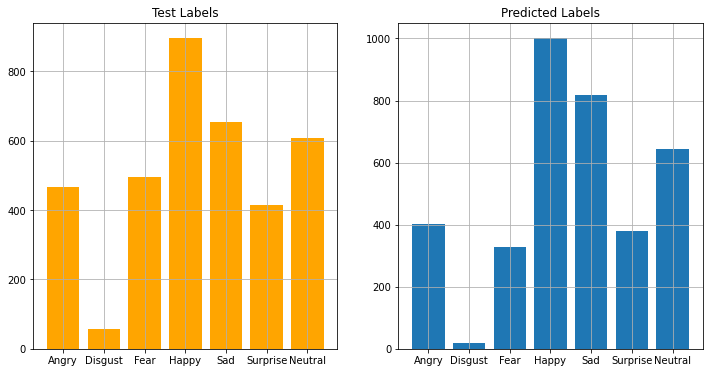

In [125]:
plot_compare_distributions(test_labels, pred_test_labels3, title1='Test Labels', title2='Predicted Labels')

#17. Analysis of Incorrect Prediction

We are using Confusion Matrix in this case.

Model 1

In [126]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels1.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

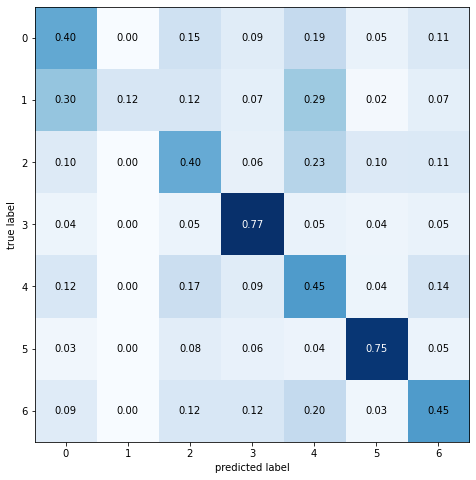

In [127]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels1.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 2

In [128]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

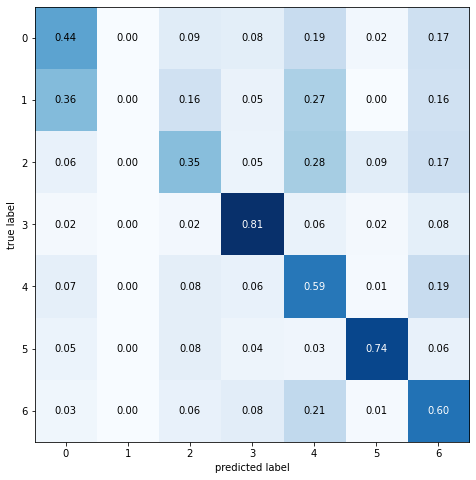

In [129]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels2.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

Model 3

In [130]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels2.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

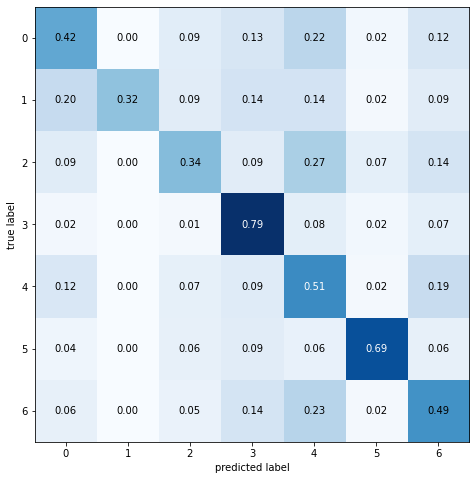

In [131]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels3.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(8, 8))
fig.show()

#Saving the Model

In [132]:
model1.save("Emotion_Detection.h5")

#Load the model for Live Emotion Detection app

In [133]:
model1.load_weights('Emotion_Detection.h5')

**Using the third party app Pycharm for my app deployment**

My app name is test.py and there the my github link where i have saved my app codes. Github:- https://github.com/rohitrv8922/Face-Emotion-Recognition-Detection.git

I am  successfull in deploying my Facial emotion detection app on Pycharm with the model accuracy of 70 %. Accuracy can be increased by training the model for longer time with more no of images which can be created by data augmentation.

#Face Recognition

The Human facial expressions are important 
for visually expressing a lot more information. 
Facial expression recognition is essential in 
the field of human-machine interaction. 
Automated facial recognition systems have 
many applications, including understanding of 
human behavior, diagnosing mental 
disorders, and synthetic human 
expression. Identifying facial expressions 
through computers with high detection rates is 
still a challenging task.
Two of the most popular methods used in the 
literature for automated FER systems are geometry and appearance. Facial expression 
recognition is usually performed in four steps, including preprocessing, face detection, feature 
extraction, and expression classification.



Human facial 
expressions are categorized into 7 universal 
emotions: happy, sad, surprised, terrified, 
angry, ugly, and neutral. Our facial emotions 
are expressed through the activation of 
specific sets of facial muscles. These are 
sometimes subtle and complex signs of 
expression that contain abundant information 
about the state of our mind. Through this, we 
can measure impacts and measurements on 
audiences / customers with ease and cost.
For example
• Retailers can use these metrics to 
assess customer interest.

• Healthcare providers can provide 
better services by using additional 
information about patients' mood 
during treatment.

• Entertainment producers can 
continually monitor audience 
engagement at events to create the 
desired content.

We are well-trained to read the 
feelings of others, in fact, at just 14 months of 
age, children can learn to  tell the difference 
between happy and sad. Computers work 
better than us in getting to the mood of 
humans. Therefore, we have 
designed/created an intensive deep learning 
neural network that gives machines the ability 
to communicate about our emotional states. 
In other words, we give eyes to the system for 
what we can see.


In this project, I have used a variety of 
intensive deeep learning techniques 
(convolutional neural networks) to identify the 
main seven human emotions: anger, hate, 
fear, joy, sadness, surprise, and neutrality.


**Data Description**

In this project work  i have 
taken the dataset from Kaggle. I am choosing this dataset because it  
consists of 48x48 pixel grayscale images of 
faces. The faces have been automatically 
registered so that the face is more or less 
centered and occupies about the same 
amount of space in each image. The task is 
to categorize each face based on the 
emotion shown in the facial expression in to 
one of seven categories (0=Angry, 
1=Disgust, 2=Fear, 3=Happy, 4=Sad, 
5=Surprise, 6=Neutral).


**Methodology**

After doing lots of research i have found that for implementing this project there are four basic steps that are 
required to be performed.

1. Preprocessing : It is a 
common name for operations with images at 
the lowest level of abstraction both input and 
output are intensity images. Most 
preprocessing steps that are implemented 
are – 

  a. Reduce the noise 

  b. Convert The 
  Image To Binary/Grayscale. 

  c. Pixel 
  Brightness Transformation. 

  d. Geometric 
  Transformation

2. Face Registration : Face Registration is a 
computer technology being used in a variety 
of applications that identifies human faces in 
digital images. In this face registration step, 
faces are first located in the image using 
some set of landmark points called “face 
localization” or “face detection”. These 
detected faces are then geometrically 
normalized to match some template image in 
a process called “faceregistration”.

3. Facial Feature Extraction : Facial 
Features extraction is an important step in 
face recognition and is defined as the 
process of locating specific regions, points, 
landmarks, or curves/contours in a given 2-D 
image or a 3D range image. In this feature 
extraction step, a numerical feature vector is 
generated from the resulting registered 
image. 
Common features that can be extracted are:- 

  a. Lips 

  b. Eyes 

  c. Eyebrows 

  d. Nose tip

4. Emotion Classification : In this step, of 
classification, the algorithm attempts to 
classify the given faces portraying one of the 
seven basic emotions.
 




**Why Facial Recognition?**

Because unlike other identification solutions such as passwords, verification by email, selfies or images, or fingerprint identification, Biometric facial recognition uses unique mathematical and dynamic patterns works as a face scanner that make this system one of the safest and most effective ones.

Perhaps one of the most well-known applications of facial recognition technology is law enforcement, where agencies can use it to find missing people, aid in solving crimes and help monitor large crowds of people.

I am making this project beacuse i really think that this technology will definetly provide benefits tovsociety, including increasing safety and security, preventing crimes, and reducing human interaction. Here are some pros of facial recognition: Helps find missing people. Protects businesses against theft.

Nowadays as the demand and craze of social media increases .The need for the Facial recognition is will really required for all the app and websites for security purposes.Right now many social media companies and app developers in some clever and convenient ways using the Face recognition feature in their apps. Facebook was one of the early adopters, utilising facial recognition to identify Facebook users in photos that were uploaded and shared.

#Limitations

1. Poor Image Quality** - When i am comparing the images to a digital camera, the quality of the scanned video is relatively poor. 

2. The recognized face is just 100 to 200 pixels wide due to the already modest image size and the target’s distance from the camera.

3. The relative angle of the target’s face has a significant impact on the recognition score. 

4. It is particularly sensitive because it is unique and can be linked to many other individual-level data. If there is a data breach, individuals will be much more at risk of identity theft because biometrics cannot be changed like a password.

5. This recognition systems are a form of mass surveillance that violate the right to privacy and threaten the rights to freedom of peaceful assembly and expression.

6. This technology is increasingly become prevalent in our lives, but its also highly vulnerable to attack.

7. It is not 100% accurate in recognising the facial expression due to which it somestime shows wrong expression of the of the face and make the system unrelavant.

8. One common misconception is that face recognition is inherently bad at identifying women or people of color. 

9.  Due to low illumination, image or video quality can lead to false positives.

10. Other biometrics methods, like fingerprints scans, are more reliable than facial recognition.

11.  The tendency of the mass adoption of facial recognition, and regulators are not catching up fast enough.

12. The background of the object also plays a significant role in Face detection. The result might not the same outdoor as compared to what is produces indoors because the factor - affecting its performance-change as soon as the locations change.

13. It is highly sensitive to pose variations. The movement of head or different camera positions can cause changes of facial texture and it will generate the wrong result.

14. If the face has beard, mustache, accessories (goggles, caps, mask, etc.) also interfere with the estimate of a face recognition system.

15. Another important factor that should be kept in mind is the different expression of the same individual. Change in facial expressions may produce a different result for the same individual.

#Improvement to be needed

1. There are multiple factors that can affect the performance of CNNs such as the cluttered
background, illumination, and posture deviation. Applying preprocessing filters can
potentially result in improved accuracy in classifying facial expressions. For example,
sharpening the images can enhance the edges of important features such as mouth and eyes. These edges are essential in predicting facial expressions.

2. By using Histogram equalization that helps  in differentiating the foreground from the background when both the colors are identical.

3. Using best models like Support Vector Machine (SVM), Hidden Markov Model, AdaBoost, and Artificial Neural Networks (ANN)9 are widely used schemes for facial expression recognition.

4. Use Fisherfaces which is one of the most successfully widely used method for face recognition.

5. Diagnostic feature training improves face matching accuracy.Previous attempts to train this ability have been largely unsuccessful, leading to conclude that face identity processing is hard-wired and not amenable to further perceptual learning.

6. May need to more focus on ocus on the ears and specific facial markings like freckles, moles, or scars, to help build facial recognition skills more better.

7. Trying to  use an atmospheric turbulence mitigation algorithm (MPE) to enhance low resolution RGB videos of faces captured either at long distances or in low light conditions. Due to its interactive nature, MPE is tuned to work well in each specific environment.

8.  While using the techniques  CRC and KNN. Where, CRC (Collaboration representation based classification) relies on the collaboration among various classes to represent an image sample. While  KNN (K-Nearest Neighbor) it is a category of classification approach that utilized to access regression purposes.

9. The purpose of the new algorithm is to recognize the faces which, depending upon the classification on the basis of both CRC and KNN.

10. Use PCA it involves the projection of an image into a new co-ordinate space, the original image is modified in order to be projected.

11. Using FAST PIXEL BASED MATCHING USING EDGE DETECTION.

#Conclusion


1.Our model is giving an accuracy of 70% on

validation set and is robust in that it works well even in a dim light environment.

2.The application is able to detect face location and predict the right expression while checking it on a local webcam.

3.The front-end of the model was made using streamlit for webapp and running well on local webapp link.

4.Finally, we successfully deployed the Streamlit WebApp on Heroku and Streamlit share that runs on a web server.

5.And I believe that through this model teachers can understand the students' perception during online classes and change the way of teaching if needed by understanding the students’ motive.